In [1]:
from sklearn.metrics.pairwise import polynomial_kernel,rbf_kernel
import numpy as np
import glob
import pickle as pk
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PolynomialFeatures
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
### creates a dictionary for the divisions

# define the paths into the container
data_path  = 'data/prob-reductions/*'

# create a list of config files

file_list  = glob.glob(data_path)

# creating data divisions dictionary

divisions_dict = {}

# getting number of divisions

n_elements = len(file_list)

print('Reading reductions...')

for i,file_name in enumerate(file_list):

    with open(file_name, 'rb') as f:
        seed = pk.load(f)

    divisions_dict[i] = seed

    # updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()


Reading reductions...
[----------------------------------------------------------------------------------------------------] 100.00% - 1 of 1

In [3]:
divisions_dict[0]['df'].head()

,px1,py1,pz1,E1,eta1,phi1,pt1,px2,py2,pz2,...,eta2,phi2,pt2,Delta_R,M12,MET,S,C,HT,A
0,-0.042585,0.784496,0.546899,0.600249,0.684867,0.517535,0.771678,-0.056977,-0.779929,0.016566,...,0.029749,-0.523045,0.779988,0.852417,0.716273,0.297703,0.280917,0.635121,0.831804,0.006756
1,0.763059,-0.073426,0.530987,0.586787,0.675903,-0.030070,0.764550,-0.762054,0.053010,-0.004497,...,-0.008334,0.977738,0.756241,0.883065,0.717262,0.352379,0.248972,0.640157,0.826404,0.000639
2,-0.740499,0.014167,0.403924,0.478337,0.573651,0.994013,0.738769,0.777818,0.013539,0.003943,...,0.007175,0.005582,0.770114,0.857969,0.665180,0.298328,0.310677,0.724349,0.809260,-0.000977
3,-0.036928,-0.780110,0.426371,0.501974,0.580454,-0.515296,0.767086,0.008120,0.804406,-0.008573,...,-0.014971,0.496817,0.802401,0.862771,0.708198,0.317165,0.289241,0.721112,0.842805,-0.002372
4,0.788076,-0.032358,-0.566500,0.622290,-0.691932,-0.012862,0.786737,-0.739775,-0.008449,-0.054355,...,-0.103271,-0.996350,0.732384,0.857720,0.683923,0.322846,0.282884,0.618096,0.822730,0.001376


In [4]:
### definig set of parameters to study

# defining attributes to use

att_list = [3,10,14,15,16,17,18]

# defining granularity

granularity = 2

In [5]:
### calculing pairrwise metrics

metrics_dict = {}


for reduction in divisions_dict:

    # Reading data and label

    data = divisions_dict[reduction]['df'].values

    data = data[:,att_list]

    y = divisions_dict[reduction]['labels']


    # Separrating signal from background

    background = data[y==0]
    
    signal = data[y==1]


    ### computing pairwise metrrics

    metrics_dict[reduction] = {
        'pairwise_score' : [],
        'local_density' : [],
        
    }

    # getting number of divisions

    n_elements = len(data)


    print('Calculating pairwise metrics...')


    for i in range(len(data)):

        # Compute the polynomial kernel

        line = data[i].reshape(1, -1)

        score = polynomial_kernel(line,data[:])


        # normalizing data

        scaler = MinMaxScaler()

        scaler.fit(score)

        score = scaler.transform(score)


        # Separating data-signal and data-background scores

        background_score = score[0,y==0]

        signal_score = score[0,y==1]


        # compute the distance sum, mean and std between background and signal samples

        background_mean_score = np.mean(background_score)

        signal_mean_score = np.mean(signal_score)


        signal_std_score = np.std(signal_score)

        background_std_score = np.std(background_score)


        dist_sum = np.sum(score**2)

        background_dist_sum = np.sum(background_score**2)

        signal_dist_sum = np.sum(signal_score**2)


        # formating pairwise results

        pairwise_result = np.array([dist_sum,
                                    background_dist_sum,
                                    background_mean_score,
                                    background_std_score,
                                    signal_dist_sum,
                                    signal_mean_score,
                                    signal_std_score])


        # calculing local density


        metrics_dict[reduction]['pairwise_score'].append(pairwise_result)
        

        # updating progress bar

        percent = (i+1)/n_elements * 100/2

        info = '{:.2f}% - {:d} of {:d}'.format(percent*2,(i+1),n_elements)

        formated_bar = '-'*int(percent) + ' '*int(50-percent)

        if i < (n_elements):

            sys.stdout.write("\r")

        sys.stdout.write('[%s] %s' % (formated_bar,info))

        sys.stdout.flush()
    
    sys.stdout.write("\r")

    print('Calculation complete!\n')


Calculating pairwise metrics...
Calculation complete!



In [6]:
np.shape(metrics_dict[reduction]['pairwise_score'])

(50000, 7)

In [ ]:
### calculating densities

sum_args = [0,1,4]

for reduction in metrics_dict:

    # Reading data and label

    data = metrics_dict[reduction]['pairwise_score']

    data = data[:,sum_args]

    y = divisions_dict[reduction]['labels']


    # Separrating signal from background

    background = data[y==0]
    
    signal = data[y==1]


    ### computing pairwise metrrics

    metrics_dict[reduction]['local_density']= {}

    # getting number of divisions

    n_elements = len(data)

    # calculating general density

    general_density = []
    np.sum[data[:,0]]/(2*n_elements*sample)


    print('Calculating pairwise metrics...')


    for i in range(len(data)):

        # Compute the polynomial kernel

        line = data[i].reshape(1, -1)

        score = polynomial_kernel(line,data[:])


        # normalizing data

        scaler = MinMaxScaler()

        scaler.fit(score)

        score = scaler.transform(score)


        # Separating signal-signal and signal-background scores

        background_score = score[0,y==0]

        signal_score = score[0,y==1]


        # compute the distance sum, mean and std between background and signal samples

        background_mean_score = np.mean(background_score)

        signal_mean_score = np.mean(signal_score)


        signal_std_score = np.std(signal_score)

        background_std_score = np.std(background_score)


        dist_sum = np.sum(score**2)

        background_dist_sum = np.sum(background_score**2)

        signal_dist_sum = np.sum(signal_score**2)


        # formating pairwise results

        pairwise_result = np.array([dist_sum,
                                    background_dist_sum,
                                    background_mean_score,
                                    background_std_score,
                                    signal_dist_sum,
                                    signal_mean_score,
                                    signal_std_score])


        # calculing local density


        metrics_dict[reduction]['pairwise_score'].append(pairwise_result)
        

        # updating progress bar

        percent = (i+1)/n_elements * 100/2

        info = '{:.2f}% - {:d} of {:d}'.format(percent*2,(i+1),n_elements)

        formated_bar = '-'*int(percent) + ' '*int(50-percent)

        if i < (n_elements):

            sys.stdout.write("\r")

            sys.stdout.write('[%s] %s' % (formated_bar,info))

            sys.stdout.flush()
    
    sys.stdout.write("\r")


# Important

In [14]:
### computing pairwise metrrics

pairwise = []


# getting number of divisions

n_elements = len(signal_train)


print('Calculating pairwise metrics...')


for i in range(len(signal_train)):

    # Compute the polynomial kernel

    line = signal_train[i]

    aux = polynomial_kernel(line,data[:])


    # compute the distance mean and std between background and signal samples

    background_mean_dist = np.mean(aux[0,y==0])

    background_std_dist = np.std(aux[0,y==0])

    signal_mean_dist = np.mean(aux[0,y==1])

    signal_std_dist = np.std(aux[0,y==1])

    result = np.array([background_mean_dist,
                    background_std_dist,
                    signal_mean_dist,
                    signal_std_dist])

    pairwise.append(result)
    

    # updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()

Calculating pairwise metrics...
[----------------------------------------------------------------------------------------------------] 100.00% - 100000 of 100000

In [15]:
pairwise = np.array(pairwise)

pairwise.shape

(100000, 4)

In [16]:
attributes = ['background mean',
            'background std',
            'signal mean',
            'signal std']

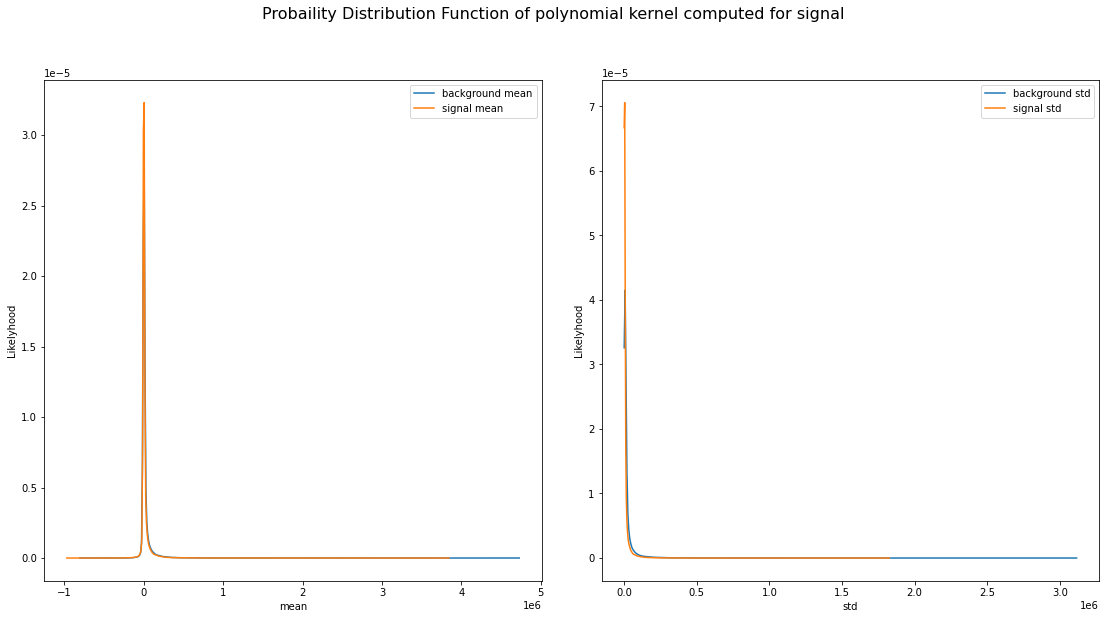

In [18]:
size_scaler = 1

fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

ax = fig.subplots(1,2)

fig.suptitle('Probaility Distribution Function of polynomial kernel computed for signal', fontsize=16)

for i,att in enumerate(attributes):

        # getting attributes values

        att_background = pairwise[:,i]


        # computing the attribute distribution

        bg_kernel = stats.gaussian_kde(att_background)


        # defining attributes limits

        bg_max = max(att_background)

        bg_min = min(att_background)


        # creating values interval for time optimization

        bg_eval = np.linspace(bg_min,bg_max,num=500)


        # calculating the likelyhood with kde kernel

        bg_likelyhood = bg_kernel(bg_eval)


        # defining plot locationg

        col = int(i%2)

        # defining label

        if col == 0: x_label = 'mean'

        else: x_label = 'std'

        # ploting results

        ax[col].plot(bg_eval, bg_likelyhood, 
                ms=3.5, linestyle='-',
                label= att)

        ax[col].legend()
        ax[col].set_xlabel(x_label)
        ax[col].set_ylabel("Likelyhood")
        ax[col].grid()


fig.tight_layout(pad=3.0)

plt.savefig('figures/polynomial-kernel-PDF.pdf',format='pdf')

del fig